## AI tool for Akaraka
The coding below is the main coding part to develop a AI/Machine Learning model for Akaraka users' to classify the intent;  

The whole development will include:  

    1. Train a model to classify the intent (Key delivery: when user input a setence, the model will identify the intent; the accuracy upto 95% when possible)  

    2. Once the intent is indenfied, the system will give the feedback

### 1. Load the dataset

In [1]:
#import neccessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud
from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#install necessary models
#!python -m spacy download en_core_web_sm
#!pip install wordcloud
#!pip install spacy


In [3]:
#import data set 
path = "assessment.csv"
df = pd.read_csv(path)

df.head(200)

,#,Setence,Intent
0,1,I want to post the assessment brief.,Post assessment brief
1,2,I need to upload the assignment details.,Post assessment brief
2,3,Show me how to post the assignment brief.,Post assessment brief
3,4,I want to create an assignment brief for stude...,Post assessment brief
4,5,Where can I upload the assessment information?,Post assessment brief
...,...,...,...
195,81,Show me how to post the exam schedule.,Post an exam info
196,82,How do I add the exam information to my course?,Post an exam info
197,83,Where can I upload the exam details for the cl...,Post an exam info
198,84,Please guide me to post the exam guidelines,Post an exam info


### 2. Pre-process, clean data and EDA

In this demo dataset, we only have two label intent" "Post assessment brief" and "Create assessment submission link"

In [4]:
#set the stop words. Stop words are common words that do not add much meaning to a sentence.
nlp = spacy.load("en_core_web_sm")
stop_words = STOP_WORDS

#create a function to tokenize the text, and remove stop words in the sentences
def tokenize(text):
    token = nlp(text)
    tokens = [word.lemma_.lower().strip() for word in token if word.lemma_ != "-PRON-"]
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens


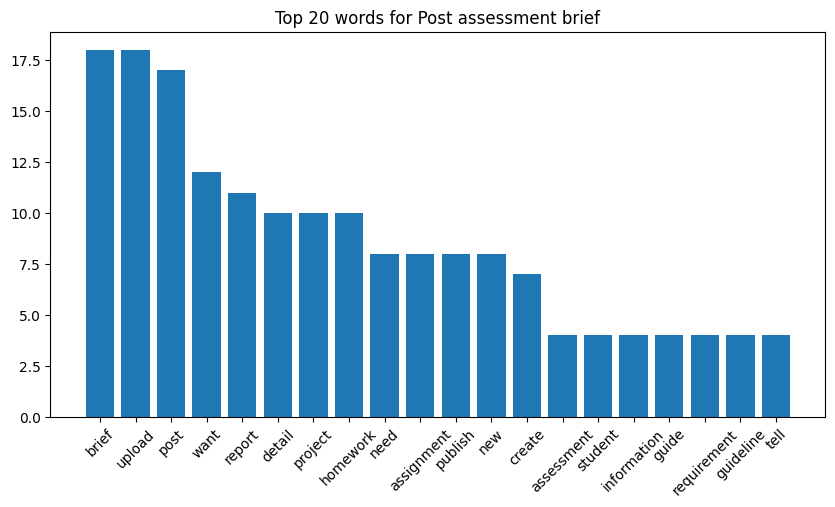

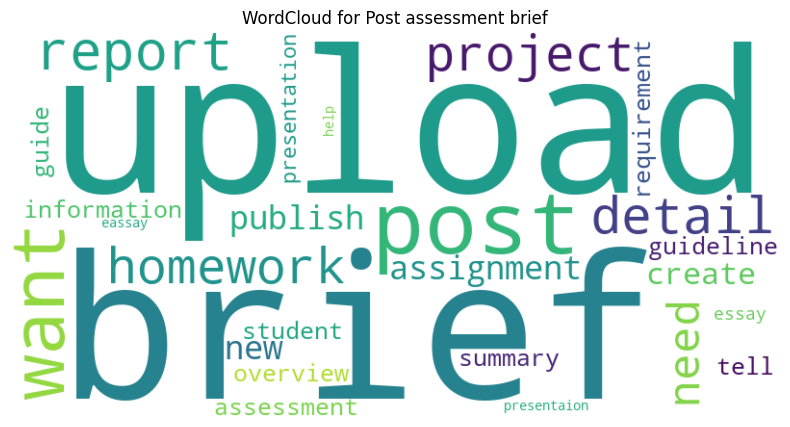

****************************************************************************************************


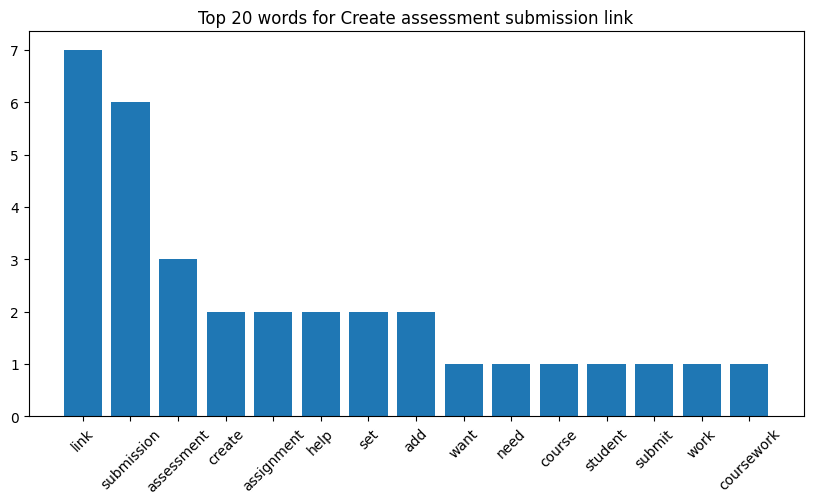

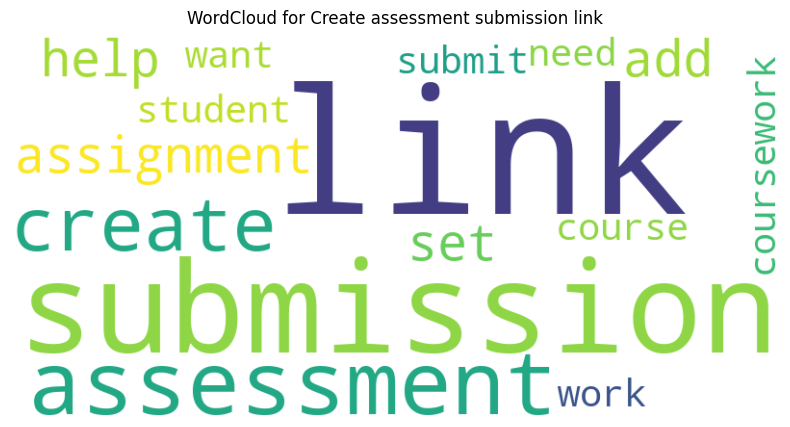

****************************************************************************************************


ValueError: not enough values to unpack (expected 2, got 0)

In [5]:
#apply the tokenize function to the sentences in the dataframe
for intent in df['Intent'].unique():
    subset = df[df['Intent'] == intent]['Setence']

    tokens = []
    for sentence in subset:
        tokens.extend(tokenize(sentence))

    counter = Counter(tokens)
    common_words = counter.most_common(20)

    #create bar chart for each intent 
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f'Top 20 words for {intent}')
    plt.show()
    
    #create word cloud map for each intent
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate_from_frequencies(counter)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {intent}')
    plt.show()

    print("*" *100)

From the chart above, we can conclude the following:  

1. For the Post Assessment Brief intent, the words “post”, “brief”, and “upload” occur most frequently. This indicates that if a sentence includes one or more of these keywords (or their combinations), it is more likely to be identified as Post Assessment Brief.  

2. For the Create Assessment Submission Link intent, the words “link”, “submission”, and “assessment” occur most frequently. This suggests that if a sentence includes one or more of these keywords (or their combinations), it is more likely to be identified as Create Assessment Submission Link.

### 3. Train and improve the model

In the following section, I will create additional columns for each sentence to represent its features.   
Here, the term "feature" refers to the measurable attributes or factors that may contribute to identifying the intent of a sentence.

In [ ]:
#Split the dataset
X = df['Setence']
y= df['Intent']

X_train,X_test,y_train,y_test= train_test_split(X, y, test_size = 0.7, random_state=42)


#### Count Vectors as features  

Count the number of times each word appears in a sentence

In [ ]:
#create a count vectorizer object 
count_vect = CountVectorizer(token_pattern= r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents 
count_vect.fit(df['Setence'])

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)


#### TF-IDF Vectors as features   
Word Level  
    Count Vectors with weighting: emphasize discriminative words with higher weights while down-weighting common words.

N-Gram Level  
    Not only consider individual words, but also adjacent word sequences (such as bigrams, trigrams, etc.).

In [ ]:
#Word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word', token_pattern= r'\w{1,}', max_features=5000)

tfidf_vect.fit(df['Setence'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)


In [ ]:
#N-gram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word', token_pattern= r'\w{1,}', ngram_range = (2, 3), max_features=5000)

tfidf_vect_ngram .fit(df['Setence'])
X_train_tfidf_ngram  = tfidf_vect_ngram .transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram .transform(X_test)

### Text / NLP based features

Create some other features.

Char_Count = Number of Characters in Text

Word Count = Number of Words in Text

Word Density = Average Number of Char in Words

Punctuation Count = Number of Punctuation in Text

Title Word Count = Number of Words in Title

Uppercase Word Count = Number of Upperwords in Text

In [ ]:
# Count number of characters, words, punctuation, uppercase words, title words in each sentence as features to consider
df['char_count'] = df['Setence'].apply(len)
df['word_count'] = df['Setence'].apply(lambda x: len(x.split()) )
df['word_density']  = df['char_count']/df['word_count']
df['punctuation_count']  = df['Setence'].apply(lambda x:len([c for c in x if c in string.punctuation]))
df['title_word_count'] = df['Setence'].apply(lambda x: len(x.split(':')[0].split()))
df['uppercase_word_count'] =df['Setence'].apply(lambda x: len([w for w in x.split() if w.isupper()]))

In [ ]:
#load spaCy model 
nlp = spacy.load("en_core_web_sm")


Part of Speech in **SpaCy**

    POS   DESCRIPTION               EXAMPLES
    ----- ------------------------- ---------------------------------------------
    ADJ   adjective                 big, old, green, incomprehensible, first
    ADP   adposition                in, to, during
    ADV   adverb                    very, tomorrow, down, where, there
    AUX   auxiliary                 is, has (done), will (do), should (do)
    CONJ  conjunction               and, or, but
    CCONJ coordinating conjunction  and, or, but
    DET   determiner                a, an, the
    INTJ  interjection              psst, ouch, bravo, hello
    NOUN  noun                      girl, cat, tree, air, beauty
    NUM   numeral                   1, 2017, one, seventy-seven, IV, MMXIV
    PART  particle                  's, not,
    PRON  pronoun                   I, you, he, she, myself, themselves, somebody
    PROPN proper noun               Mary, John, London, NATO, HBO
    PUNCT punctuation               ., (, ), ?
    SCONJ subordinating conjunction if, while, that
    SYM   symbol                    $, %, §, ©, +, −, ×, ÷, =, :), 😝
    VERB  verb                      run, runs, running, eat, ate, eating
    X     other                     sfpksdpsxmsa
    SPACE space
    
Find out number of Adjective, Adverb, Noun, Numeric, Pronoun, Proposition, Verb.

In [ ]:
# Initialize some columns for feature's count 
df['adj_count'] = 0
df['adv_count'] = 0
df['noun_count'] = 0
df['num_count'] = 0
df['pron_count'] = 0
df['propn_count'] = 0
df['verb_count'] = 0

In [ ]:
#create a function to count the number of different parts of speech in each sentence
def pos_count(text):
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    return pos_counts

# Apply the function to each sentence in the dataframe and update the counts 
for index, row in df.iterrows():
    counts = pos_count(row['Setence'])
    df.at[index, 'adj_count'] = counts.get('ADJ', 0)
    df.at[index, 'adv_count'] = counts.get('ADV', 0)
    df.at[index, 'noun_count'] = counts.get('NOUN', 0)
    df.at[index, 'num_count'] = counts.get('NUM', 0)
    df.at[index, 'pron_count'] = counts.get('PRON', 0)
    df.at[index, 'propn_count'] = counts.get('PROPN', 0)
    df.at[index, 'verb_count'] = counts.get('VERB', 0)

df.head()




,#,Setence,Intent,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count
0,1,I want to post the assessment brief.,Post assessment brief,36,7,5.142857,1,7,1,0,0,2,0,1,0,2
1,2,I need to upload the assignment details.,Post assessment brief,40,7,5.714286,1,7,1,0,0,2,0,1,0,2
2,3,Show me how to post the assignment brief.,Post assessment brief,41,8,5.125000,1,8,0,0,0,2,0,1,0,2
3,4,I want to create an assignment brief for stude...,Post assessment brief,50,9,5.555556,1,9,1,0,0,3,0,1,0,2
4,5,Where can I upload the assessment information?,Post assessment brief,46,7,6.571429,1,7,1,0,0,2,0,1,0,1


Now, we have created several columns to capture different features of those sentences. Next, we will investigate which features may have a greater impact.

In [ ]:
cols = [
    'char_count', 'word_count', 'word_density',
    'punctuation_count', 'title_word_count',
    'uppercase_word_count', 'adj_count',
    'adv_count', 'noun_count', 'num_count',
    'pron_count', 'propn_count', 'verb_count']

df[cols].sample(5)

,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count
25,35,7,5.000000,1,7,1,0,0,2,0,1,0,2
48,40,7,5.714286,0,7,0,1,0,2,0,0,0,1
144,34,7,4.857143,1,7,1,0,0,2,0,1,0,2
109,51,10,5.100000,1,10,0,0,0,2,0,2,0,2
55,35,7,5.000000,1,7,0,1,0,1,0,1,0,2


#### Topic Models as Features 

In [ ]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components = 20, learning_method = 'online', max_iter = 20)

X_topics = lda_model.fit_transform(X_train_count)
topic_word = lda_model.components_
vocab = count_vect.get_feature_names_out()

In [ ]:
vocab

array(['16', '25', 'a', 'about', 'activities', 'activity', 'add', 'ai',
       'an', 'and', 'announcement', 'answer', 'are', 'assessment',
       'assign', 'assignment', 'book', 'brief', 'build', 'can', 'canada',
       'capital', 'check', 'chocolate', 'city', 'class', 'content',
       'cook', 'could', 'countries', 'course', 'coursework', 'create',
       'date', 'detail', 'details', 'discussion', 'do', 'documents',
       'does', 'dogs', 'dolphins', 'earth', 'eassay', 'eat',
       'educational', 'essay', 'everest', 'exam', 'fact', 'far', 'field',
       'final', 'flight', 'fly', 'for', 'forum', 'french', 'from', 'fun',
       'gas', 'gdp', 'go', 'google', 'greeting', 'group', 'groups',
       'guide', 'guidelines', 'help', 'homework', 'how', 'i', 'in',
       'info', 'information', 'instructions', 'internet', 'into',
       'invented', 'is', 'it', 'japan', 'joke', 'know', 'lab', 'latest',
       'learning', 'lecture', 'lesson', 'like', 'link', 'links', 'list',
       'long', 'make',

In [ ]:
# 'vocab' represents the vocabulary extracted from the training data. 
# It is the list of all unique words (features) identified by CountVectorizer. 
# Each index in 'vocab' corresponds to a column in the document-term matrix.

# 'topic' (from lda_model.components_) represents the learned topics. 
# Each topic is a distribution over the words in 'vocab', 
# where higher weights indicate that a word is more strongly associated with that topic.
# In other words, topics are groups of words that often appear together 
# and capture the latent semantic structure of the text.

# The below code prints the top 10 words for each topic,
# which helps to interpret what each topic is about.

In [ ]:
# view the topic models
n_top_words = 10
topic_summaries = []
print('Group Top Words')
print('-----', '-'*80)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    top_words = ' '.join(topic_words)
    topic_summaries.append(top_words)
    print('  %3d %s' % (i, top_words))

Group Top Words
----- --------------------------------------------------------------------------------
    0 create project i a for to want class groups brief
    1 learning upload i want resources take guide outdoor submit topic
    2 to i upload a want the how me post details
    3 the city of capital canada what s reset how my
    4 the how i my do course is to add tutorial
    5 trip show to practice me forum post how this guide
    6 the i upload class can where for this information welcome
    7 post me how show pasta exam into to reading info
    8 lesson question work video workshop quiz need q essay list
    9 the project old universe via post to how details activity
   10 i a me the to please for help exam share
   11 the i where can upload information class this for up
   12 a want to i upload discussion essay post new class
   13 a video where i details new how can test information
   14 presentation want the brief tonight know assign french eassay activity
   15 book ticke

### Modelling

In [ ]:
#create a function to train models and return accuracy score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)


In [ ]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors'
                                  ])

#### Naive Bayes Classifier

In [ ]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.4211

CPU times: total: 0 ns
Wall time: 6 ms


In [ ]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.3383

CPU times: total: 0 ns
Wall time: 6 ms


In [ ]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.2932

CPU times: total: 0 ns
Wall time: 5 ms


In [ ]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

#### Linear Classifier

In [ ]:
%%time
# Linear Classifier on Count Vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350), X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.4511

CPU times: total: 31.2 ms
Wall time: 27 ms


In [ ]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF : 0.3985

CPU times: total: 15.6 ms
Wall time: 14 ms


In [ ]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.3684

CPU times: total: 62.5 ms
Wall time: 40 ms


In [ ]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

#### Support Vector Machine

In [ ]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(), X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.6767

CPU times: total: 15.6 ms
Wall time: 7 ms


In [ ]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF : 0.6917

CPU times: total: 0 ns
Wall time: 6 ms


In [ ]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)

SVM, N-Gram Vectors   : 0.3759

CPU times: total: 15.6 ms
Wall time: 6 ms


In [ ]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

#### Bagging Models 

In [ ]:
%%time
# Bagging (Random Forest) on Count Vectors
accuracy1 = train_model(RandomForestClassifier(n_estimators = 100), X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.4812

CPU times: total: 266 ms
Wall time: 252 ms


In [ ]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
accuracy2 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf, y_train, X_test_tfidf)
print('RF, WordLevel TF-IDF : %.4f\n' % accuracy2)

RF, WordLevel TF-IDF : 0.3910

CPU times: total: 234 ms
Wall time: 222 ms


In [ ]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
accuracy3 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.3233

CPU times: total: 234 ms
Wall time: 239 ms


In [ ]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

#### Boosting Models 

In [ ]:
%%time
# Gradient Boosting on Count Vectors
accuracy1 = train_model(GradientBoostingClassifier(), X_train_count, y_train, X_test_count)
print('GB, Count Vectors    : %.4f\n' % accuracy1)

GB, Count Vectors    : 0.6842

CPU times: total: 2.23 s
Wall time: 2.33 s


In [ ]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
accuracy2 = train_model(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf)
print('GB, WordLevel TF-IDF : %.4f\n' % accuracy2)

GB, WordLevel TF-IDF : 0.6466

CPU times: total: 2.45 s
Wall time: 2.57 s


In [ ]:
%%time
# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy3 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

GB, N-Gram Vectors   : 0.3910

CPU times: total: 3.66 s
Wall time: 3.75 s


In [ ]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

### Result and improvement

In [ ]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.421053,0.338346,0.293233
Logistic Regression,0.451128,0.398496,0.368421
Support Vector Machine,0.676692,0.691729,0.375940
Random Forest,0.481203,0.390977,0.323308
Gradient Boosting,0.684211,0.646617,0.390977


Insight:  
1. Navie Bayes seems perfectly working in Count Vectors, but it could be overfitting due the volumn of the data.  
2. Gradient Boosting have general better performance accross all three features compared with other models. 
  
  
Further Action:  
1. Conduct a cross-validation
2. Use classification report to evaluate other results 

In [ ]:
#Conduct a cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Create a new DataFram to store the results 
mean_results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors'
                                  ])

models = [
    ('Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=350)),
    ('Linear SVC', LinearSVC()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
]

for name, est in models:
    scores1 = cross_val_score(est, X_train_count, y_train, cv=5).mean()
    scores2 = cross_val_score(est, X_train_tfidf, y_train, cv=5).mean()
    scores3 = cross_val_score(est, X_train_tfidf_ngram, y_train, cv=5).mean()
    mean_results.loc[name] = {
        'Count Vectors': scores1,
        'WordLevel TF-IDF': scores2,
        'N-Gram Vectors': scores3}


In [ ]:
print(mean_results)

                     Count Vectors  WordLevel TF-IDF  N-Gram Vectors
Naive Bayes               0.390909          0.319697        0.250000
Logistic Regression       0.571212          0.392424        0.286364
Linear SVC                0.607576          0.696970        0.484848
Random Forest             0.518182          0.481818        0.390909
Gradient Boosting         0.786364          0.624242        0.395455


From the above, we can see that Gradient Boosting has a better performance in general. Thus, in the following section, we will be using Gradient Boosting. 

#### Fit model, predict and Confusion Matrix

In [ ]:
#fit the model and make the predictions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
#from imblearn.over_sampling import SMOTE

#set binary classification for logistic regression and gradient boosting
#POS_NAME = "Post assessment brief"
#y_train_bin = (y_train == POS_NAME).astype(int)
#y_test_bin  = (y_test  == POS_NAME).astype(int)

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="word", token_pattern=r"\w{1,}", 
                              ngram_range=(1,2), max_features=5000)),
    ("lr", LogisticRegression(max_iter=1000))
])

to_dense = FunctionTransformer(lambda x: x.todense(), accept_sparse=True)
pipe_gb = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer = "char_wb", token_pattern= r'\w{1,}', ngram_range = (3,5), max_features=5000)),
    ("gb", GradientBoostingClassifier(random_state=42))
])

#fit and train the model
pipe_lr.fit(X_train, y_train)
pipe_gb.fit(X_train, y_train)

#prediction 
y_pre_lr = pipe_lr.predict(X_test)
y_pre_gb = pipe_gb.predict(X_test)

#print the classification report 
print("Logistic Regression classification_report:\n",classification_report(y_test, y_pre_lr))
print("Gradient Boosting classification_report:\n",classification_report(y_test, y_pre_gb))

Logistic Regression classification_report:
                                                                         precision    recall  f1-score   support

                                                         Create a quiz       0.00      0.00      0.00         7
                                                         Create a test       0.00      0.00      0.00         4
                                     Create assessment submission link       0.00      0.00      0.00         5
Group membership(e.g. for group work, or selecting a tutorial session)       0.00      0.00      0.00         7
                                                               Others        0.34      0.75      0.47        16
                                                     Post an exam info       0.00      0.00      0.00         8
                                                 Post assessment brief       0.37      1.00      0.54        36
                                           Post field trip 

The report above showing that a better performance of Gradient Boosting, and the model pipeline is created.  
Following next, I will be using a some new dataset to further test the model. 

In [ ]:
new_setences =[
    "I want to book a flight to New York",
    "What is the GDP of Japan?",
    "How do I reset my password?",
    "Can you show me how to put up a welcome message",
    "Please help me post the exam info.",
    "Show me how to post the exam schedule.",
    "How do I add the exam information to my course?",
    "Where can I upload the exam details for the class?",
    "Please guide me to post the exam guidelines",
    "I want to create a new assignment",
    "How do I set up a new assignment for my students?",
    "Can you help me create a new assignment?",
    "Please assist me in setting up a new assignment",
    "I want to upload a new project information",
    "Post a new brief for the essay",
    "I want to upload a new presentation details"
]
new_df = pd.DataFrame(new_setences, columns=['Setence'])

y_pre_new = pipe_gb.predict(new_df['Setence'])
new_df['Intenet'] = y_pre_new

new_df


,Setence,Intenet
0,I want to book a flight to New York,Others
1,What is the GDP of Japan?,Others
2,How do I reset my password?,Others
3,Can you show me how to put up a welcome message,Post welcome information
4,Please help me post the exam info.,Post an exam info
5,Show me how to post the exam schedule.,Post an exam info
6,How do I add the exam information to my course?,Post an exam info
7,Where can I upload the exam details for the cl...,Post an exam info
8,Please guide me to post the exam guidelines,Post an exam info
9,I want to create a new assignment,Post assessment brief


In [ ]:
#save the model in the pineline 
import joblib 

joblib.dump(pipe_gb, 'gb_model.pkl')

['gb_model.pkl']